In [82]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_absolute_error , mean_squared_error,r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.layers import Dense,Activation,Dropout,Input,SimpleRNN
from keras.models import Sequential
from keras.callbacks import EarlyStopping


In [83]:
df = pd.read_csv(r"D:\python_jupty\機器學習作業\大里補值完.csv")
df_test = pd.read_csv(r"D:\python_jupty\機器學習作業\大里補值完_2022.csv")

In [84]:
df_test

,time,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR,aqi
0,2022/1/1 12:00 AM,15.4,2.24,0.44,0.17,1.5,21.7,23.3,6.8,41,27,0.0,78,2.1,2.41,269,278,1.9,1.4,54
1,2022/1/1 12:57 AM,15.1,2.29,0.45,0.17,1.9,21.2,23.2,7.1,45,31,0.0,80,2.1,2.46,277,318,1.1,1.0,60
2,2022/1/1 1:55 AM,15.8,2.22,0.45,0.14,1.7,21.7,23.5,9.3,41,28,0.0,78,2.0,2.36,11,112,1.1,0.3,67
3,2022/1/1 3:07 AM,15.5,2.85,0.47,0.19,2.0,21.3,23.3,5.4,42,31,0.0,79,1.8,3.04,145,226,0.9,0.4,71
4,2022/1/1 4:04 AM,15.3,2.47,0.49,0.23,2.9,22.7,25.6,1.5,47,35,0.0,81,1.8,2.70,200,260,1.1,0.4,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2022/12/31 6:57 PM,18.9,2.11,0.43,0.11,1.0,16.9,17.9,21.4,16,11,0.0,72,1.8,2.22,356,15,1.7,1.1,36
8756,2022/12/31 7:55 PM,18.5,2.14,0.45,0.11,0.9,16.5,17.5,19.4,20,10,0.0,74,1.9,2.25,349,315,1.0,0.9,34
8757,2022/12/31 9:07 PM,18.5,2.20,0.51,0.14,1.0,20.1,21.1,14.3,25,9,0.0,75,2.0,2.34,336,321,1.3,0.6,31
8758,2022/12/31 10:04 PM,18.3,2.13,0.44,0.11,0.9,17.9,18.8,15.7,16,10,0.0,77,1.8,2.24,352,12,1.1,1.1,33


In [85]:
df_selected = df.drop(columns=['time','truetime','WIND_DIREC','WD_HR','WIND_SPEED','WS_HR','RAINFALL','RH','AMB_TEMP','CH4','NMHC','NO','NOx','THC'], inplace=False)#去掉的feature
df_selected_test = df_test.drop(columns=['time','WIND_DIREC','WD_HR','WIND_SPEED','WS_HR','RAINFALL','RH','AMB_TEMP','CH4','NMHC','NO','NOx','THC'], inplace=False)#去掉的feature
sel_data = 'aqi'  

# Train Test split

In [86]:
import math


time_steps = 3
train = df_selected

test = df_selected_test

In [87]:
train_temp = train.to_numpy()
test_temp = test.to_numpy()

scaler = MinMaxScaler(feature_range=(0, 1))

train_np= scaler.fit_transform(train_temp)
test_np= scaler.fit_transform(test_temp)

In [88]:
print(train_np.shape)

print(test_np.shape)

(8760, 7)
(8760, 7)


# Train

In [89]:
from tqdm import tqdm
X_train = []
y_train = []

for i in tqdm(range(len(train_np) - time_steps)):
    X_train.append(train_np[i:i+time_steps])
    y_train.append(train_np[i+time_steps])

X_train = np.array(X_train)
y_train = np.array(y_train)

print(X_train.shape)
print(y_train.shape)

100%|██████████| 8757/8757 [00:00<00:00, 1750525.22it/s]

(8757, 3, 7)
(8757, 7)


# Test

In [90]:
x_test = []
y_test = []


for i in tqdm(range(len(test_np)-time_steps)):
    x_test.append(test_np[i:i+time_steps])


y_test= test['aqi']

x_test = np.array(x_test)
y_test = np.array(y_test)

print(x_test.shape)
print(y_test.shape)


100%|██████████| 8757/8757 [00:00<00:00, 1751443.43it/s]

(8757, 3, 7)
(8760,)


# Model

In [91]:
opt = keras.optimizers.Adam(learning_rate=0.005)


model = Sequential()
model.add(Input(shape=(X_train.shape[1],  X_train.shape[2])))  

model.add(SimpleRNN(32,return_sequences=True,activation='relu') )
model.add(SimpleRNN(16,return_sequences=False,activation='relu') )
 
model.add( Dense(X_train.shape[2],activation='relu') )
model.compile(optimizer=opt, loss='mse')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)


model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_8 (SimpleRNN)        │ (None, 3, 32)          │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_9 (SimpleRNN)        │ (None, 16)             │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,183 (8.53 KB)

 Trainable params: 2,183 (8.53 KB)

 Non-trainable params: 0 (0.00 B)

In [92]:

tt = 50
history = model.fit(X_train,y_train,batch_size=20,validation_split=0.1,epochs=tt,callbacks=[es],verbose=1,shuffle=False)

Epoch 1/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0121 - val_loss: 0.0030
Epoch 2/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 3/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 4/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 5/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 6/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 7/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 8/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 9/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 10/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 11/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 12/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

# Predict

In [154]:
import random

j = 0
num_steps_to_show = 8
initial_sequence = []
initial_sequence.append(test_np[j:j+time_steps])
initial_sequence = np.array(initial_sequence)


In [155]:
sequence = []
temp = X_train.shape[2]
for i in range(num_steps_to_show):
    new_prediction = model.predict(initial_sequence)

    initial_sequence = initial_sequence[0][1:]
    
    initial_sequence = np.append(initial_sequence,new_prediction,axis=0).reshape(-1,time_steps,X_train.shape[2])
    sequence.append(new_prediction[0][temp-1])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [156]:
sc = MinMaxScaler(feature_range=(0, 1))
y_test= y_test.reshape(-1, 1)
sc.fit(y_test)

sequence = sc.inverse_transform(np.array(sequence).reshape(8,1))

In [157]:
sequence=sequence.astype(int)

In [158]:


mse =mean_squared_error(y_test[j+time_steps:j+time_steps+num_steps_to_show],sequence)
mse
rmse = np.sqrt(mse)
print('rmse:'   ,rmse)
print('mse:',mse)


rmse: 1.2747548783981961
mse: 1.625


# 圖

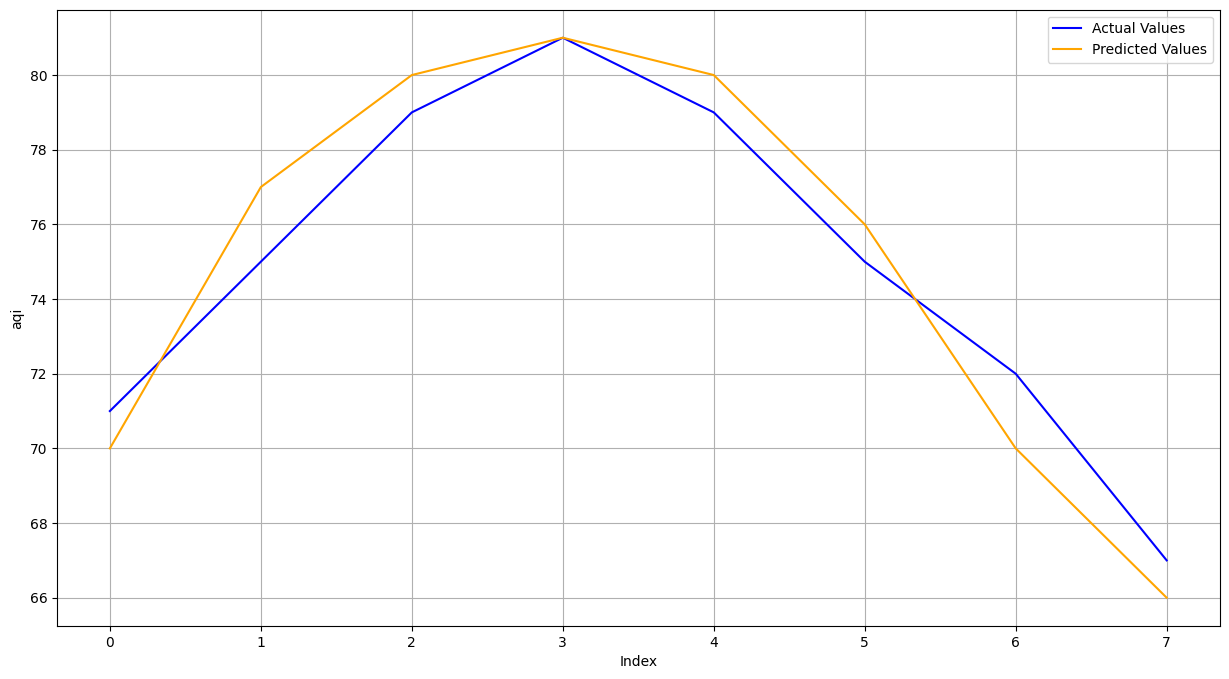

In [159]:

plt.figure(figsize=(15, 8))
plt.plot(y_test[j+time_steps:j+time_steps+num_steps_to_show], label='Actual Values', color='blue', linestyle='-')
plt.plot(sequence[:num_steps_to_show], label='Predicted Values', color='orange', linestyle='-')
plt.xlabel('Index')
plt.ylabel('aqi')
plt.legend()
plt.grid(True)
plt.show()